# MNIST Dataset

Sources:
  1. https://www.tensorflow.org/get_started/mnist/beginners
  2. https://www.tensorflow.org/get_started/mnist/pros
  3. https://github.com/random-forests/tensorflow-workshop/blob/master/examples/02_logistic_regression_low_level.ipynb

The [MNIST dataset](http://yann.lecun.com/exdb/mnist) consists of handwritten digit images and it is divided in 60,000 examples for the training set and 10,000 examples for testing. In many papers as well as in this tutorial, the official training set of 60,000 is divided into an actual training set of 50,000 examples and 10,000 validation examples (for selecting hyper-parameters like learning rate and size of the model). All digit images have been size-normalized and centered in a fixed size image of 28 x 28 pixels. In the original dataset each pixel of the image is represented by a value between 0 and 255, where 0 is black, 255 is white and anything in between is a different shade of grey.

Let's start by download the dataset and inspecting some of the images.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

# It will be downloaded to './data' if you don't already have a local copy.
mnist = input_data.read_data_sets('./data', one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


The MNIST data is split into three parts: 55,000 data points of training data (``mnist.train``), 10,000 points of test data (``mnist.test``), and 5,000 points of validation data (``mnist.validation``). This split is very important: it's essential in machine learning that we have separate data which we don't learn from so that we can make sure that what we've learned actually generalizes!

As mentioned earlier, every MNIST data point has two parts: an image of a handwritten digit and a corresponding label. We'll call the images "x" and the labels "y". Both the training set and test set contain images and their corresponding labels; for example the training images are ``mnist.train.images`` and the training labels are ``mnist.train.labels``.

In [2]:
print ('Train, validation, test: %d, %d, %d' %
      (len(mnist.train.images), len(mnist.validation.images), len(mnist.test.images)))

Train, validation, test: 55000, 5000, 10000


Each image is 28 pixels by 28 pixels:

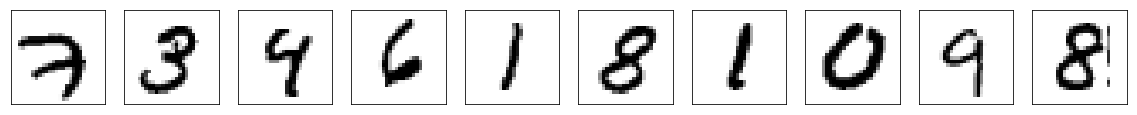

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    ax.imshow(mnist.train.images[i].reshape(28, 28), cmap=plt.cm.gray_r)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

We can flatten this array into a vector of 28x28 = 784 numbers. It doesn't matter how we flatten the array, as long as we're consistent between images. From this perspective, the MNIST images are just a bunch of points in a 784-dimensional vector space.

The result is that ``mnist.train.images`` is a tensor (an n-dimensional array) with a shape of ``[55000, 784]``. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. Each entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

In [4]:
mnist.train.images.shape

(55000, 784)

Each image in MNIST has a corresponding label, a number between 0 and 9 representing the digit drawn in the image.

For the purposes of this tutorial, we're going to want our labels as "one-hot vectors". A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the
th digit will be represented as a vector which is 1 in the th dimension.
For example, 3 would be ``[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]``. Consequently, ``mnist.train.labels`` is a ``[55000, 10]`` array of floats.

In [5]:
mnist.train.labels.shape

(55000, 10)

# Softmax Regression

We know that every image in MNIST is of a handwritten digit between zero and nine. So there are only ten possible things that a given image can be. We want to be able to look at an image and give the probabilities for it being each digit. For example, our model might look at a picture of a nine and be 80% sure it's a nine, but give a 5% chance to it being an eight (because of the top loop) and a bit of probability to all the others because it isn't 100% sure.

The setup will be similar to the previous notebook on linear regression. The principal changes are:
* We have switched from regression to classification.
* We are using a different loss function. Instead of using squared error, we will now use cross-entropy.
* We are using a new dataset. MNIST contains 28x28 pixel handwritten digits.

An important takeaway: notice that despite these changes, the line that creates the gradient descent optimizer is identical to the previous notebook. This is the magic of automatic differentiation. Once we've specified our graph and the loss function, TensorFlow is able to analyze it for us, and determine how to adjust our variables to decrease the loss.

The model we train here is unimpressive in terms of accuracy. The goal is to introduce you to the dataset.

In [6]:
from os.path import join

import numpy as np
import tensorflow as tf

Initialize a new ``tf.Session``.

In [7]:
tf.reset_default_graph()
sess = tf.Session()

Define constants we will be using later on.

In [8]:
NUM_CLASSES = 10
NUM_PIXELS = 28 * 28
TRAIN_STEPS = 2000
BATCH_SIZE = 100
LEARNING_RATE = 0.5

## Linear predictor

We begin by defining placeholders for the input.

In [9]:
images = tf.placeholder(dtype=tf.float32, shape=[None, NUM_PIXELS])
labels = tf.placeholder(dtype=tf.float32, shape=[None, NUM_CLASSES])

We want to be able to input any number of MNIST images, each flattened into a 784-dimensional vector. We represent this as a 2-D tensor of floating-point numbers, with a shape ``[None, 784]`` (Here ``None`` means that a dimension can be of any length.)

Next, we'll define the weights and intercepts for our model.

In [10]:
with tf.name_scope('linear_predictor'):
    W = tf.Variable(tf.truncated_normal([NUM_PIXELS, NUM_CLASSES]))
    b = tf.Variable(tf.zeros([NUM_CLASSES]))
    µ = tf.matmul(images, W) + b

Notice that ``W`` has a shape of ``[784, 10]`` because we want to multiply the 784-dimensional image vectors by it to produce 10-dimensional vectors of evidence for the different classes. ``b`` has a shape of ``[10]`` so we can add it to the output. We initialize the weights ``W`` with 2-D matrix generated by ``tf.truncated_normal``, which generates a random distribution with mean zero and unit standard deviation. The intercepts ``b`` are initialized with a 1-D vector of all zeros.

Finally, our linear predictor is $\mu_i = \mathbf{W} \mathbf{x}_i + b$, where $\mathbf{x}$ is the 784-dimensional vector of the $i$-th image.

## Loss function

In order to train our model, we need to define what it means for the model to be good. Well, actually, in machine learning we typically define what it means for a model to be bad. We call this the *cost*, or the *loss*, and it represents how far off our model is from our desired outcome. We try to minimize that error, and the smaller the error margin, the better our model is.

One very common, very nice function to determine the loss of a model is called **cross-entropy**. Cross-entropy arises from thinking about information compressing codes in information theory but it winds up being an important idea in lots of areas, from gambling to machine learning. It's defined as:
$$
H_{y'}(y) = -\sum_i y'_i \log(y_i)
$$

Where $y$ is our predicted probability distribution, and $y^\prime$ is the true distribution (the one-hot vector with the digit labels). In some rough sense, the cross-entropy is measuring how inefficient our predictions are for describing the truth.

We can implement the cross-entropy function as
```python
y = tf.nn.softmax(µ)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(labels * tf.log(y), reduction_indices=[1]))
```

First, ``tf.log`` computes the logarithm of each element of ``y``. Next, we multiply each element of ``labels`` with the corresponding element of ``tf.log(y)``. Then ``tf.reduce_sum`` adds the elements in the second dimension of ``y``, due to the ``reduction_indices=[1]`` parameter. Finally, ``tf.reduce_mean`` computes the mean over all the examples in the batch.

Note that in the source code, we don't use this formulation, because it is numerically unstable. Instead, we apply ``tf.nn.softmax_cross_entropy_with_logits`` on the unnormalized logits (e.g., we call ``softmax_cross_entropy_with_logits`` on ``µ``, because this more numerically stable function internally computes the softmax activation. In your code, consider using ``tf.nn.softmax_cross_entropy_with_logits`` instead.

In [11]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=µ, labels=labels))

with tf.name_scope('optimizer'):
    train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss) 

## Evaluating our model

How well does our model do?

Well, first let's figure out where we predicted the correct label. ``tf.argmax`` is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. For example, ``tf.argmax(y,1)`` is the label our model thinks is most likely for each input, while ``tf.argmax(y_,1)`` is the correct label. We can use ``tf.equal`` to check if our prediction matches the truth.

In [12]:
with tf.name_scope('evaluation'):
    prediction = tf.argmax(µ, 1)
    predicted_vs_actual = tf.equal(prediction, tf.argmax(labels, 1))
    model_accuracy = tf.reduce_mean(tf.cast(predicted_vs_actual, tf.float32))

``predicted_vs_actual`` us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean (``model_accuracy``). For example, ``[True, False, True, True]`` would become ``[1,0,1,1]`` which would become 0.75.

## Training the model

Before starting the traning, we setup summary statistics to be visualized in TensorBoard.

In [13]:
# Write the graph
LOGDIR = './graphs'

writer = tf.summary.FileWriter(join(LOGDIR, '02_logistic_regression'))
writer.add_graph(sess.graph)

Here, we'll be using [tf.summary.histogram](https://www.tensorflow.org/get_started/tensorboard_histograms), which constructs a histogram of the weights ``W`` in each iteration of training.

In [14]:
with tf.name_scope('summaries'):
    tf.summary.histogram('weights', W)
    tf.summary.scalar('accuracy', model_accuracy)

# This op will calculate our summary data when run
summary_op = tf.summary.merge_all()

Initalize variables.

In [15]:
sess.run(tf.global_variables_initializer())

Let's train – we'll run the training step 2000 times!

In [16]:
for i in range(TRAIN_STEPS):
    batch_images, batch_labels = mnist.train.next_batch(BATCH_SIZE)
    summary_result, _ = sess.run([summary_op, train_step],
                                 feed_dict={images: batch_images, labels: batch_labels})

    # write the summary data to disk
    writer.add_summary(summary_result, i)

writer.close()

Each step of the loop, we get a "batch" of one hundred random data points from our training set. We run ``train_step`` feeding in the batches data to replace the placeholders.

Using small batches of random data is called stochastic training – in this case, stochastic gradient descent. Ideally, we'd like to use all our data for every step of training because that would give us a better sense of what we should be doing, but that's expensive. So, instead, we use a different subset every time. Doing this is cheap and has much of the same benefit.

Finally, we evaluate the trained model on our test data.

In [17]:
print("Accuracy %f" % sess.run(model_accuracy, feed_dict={images: mnist.test.images, 
                                                    labels: mnist.test.labels}))

Accuracy 0.900100


This should be about 90-92%.

Is that good? Well, not really. In fact, it's pretty bad. This is because we're using a very simple model. With some small changes, we can get to 97%. The best models can get to over 99.7% accuracy! (For more information, have a look at this [list of results](https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results)).

## Making predictions

As written, this code evaluates the accuracy of the trained model on the entire testing set. Below is a function to predict the label for a single image.

In [18]:
def predict(i):
    image = mnist.test.images[i]
    actual_label = np.argmax(mnist.test.labels[i])
    predicted_label = sess.run(prediction, feed_dict={images: [image]})
    return predicted_label, actual_label

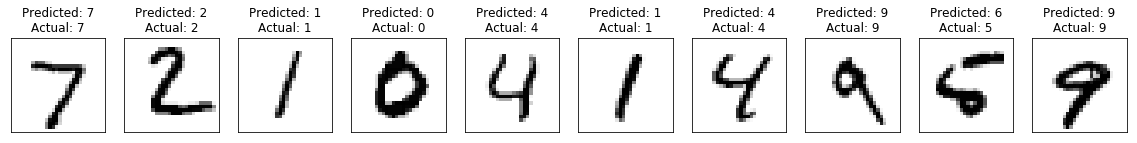

In [19]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    ax.imshow(mnist.test.images[i].reshape(28, 28), cmap=plt.cm.gray_r)
    predicted, actual = predict(i)
    ax.set_title("Predicted: %d\nActual: %d" % (predicted, actual))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)